In [200]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import statsmodels.api as sm



from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy import stats

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, scale
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from statsmodels.api import Logit

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from statsmodels.api import qqplot
from statsmodels.api import add_constant
# 분류 Decision Tree
from sklearn.tree import DecisionTreeClassifier
# 분류 Random Forest
from sklearn.ensemble import RandomForestClassifier
# 분류 Gradient Boosting 
from sklearn.ensemble import GradientBoostingClassifier
# 분류 NN (MLPClassifier)
from sklearn.neural_network import MLPClassifier

# 모델 성능 평가: Precision, Recall, F1 Score, ROC Curve, AUC
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report

# Check the Frequency of Variable
from collections import Counter
%matplotlib inline
rc('font', family='NanumGothic')

plt.rcParams['axes.unicode_minus'] = False


In [201]:
df_users_raw = pd.read_csv('/home/piai/바탕화면/cvs_users.csv', encoding="cp949")
df_users_raw.head()

,idUser,Gender,AgeGroup
0,U100001,남성,40대
1,U100002,여성,30대
2,U100003,남성,30대
3,U100004,남성,30대
4,U100005,여성,30대


In [202]:
df_users_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098 entries, 0 to 1097
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   idUser    1098 non-null   object
 1   Gender    1098 non-null   object
 2   AgeGroup  1098 non-null   object
dtypes: object(3)
memory usage: 25.9+ KB


In [203]:
df_users_raw.isnull().sum()

idUser      0
Gender      0
AgeGroup    0
dtype: int64

결측치는 존재하지 않는다.

In [204]:
df_users_raw.describe()

,idUser,Gender,AgeGroup
count,1098,1098,1098
unique,1098,2,6
top,U100001,남성,30대
freq,1,731,352


idUser에는 모두 다른 값이 들어있고 총 1098명의 User가 있다.

Gender는 남성 여성이 있고, 남성은 731명/ 여성은 368명이 있다.

Agegroup은 총 6개(10대, 20대, 30대, 40대, 50대, 60대이상)가 있고, 30대가 352명으로 가장 많다.

In [205]:
print(df_users_raw.groupby("Gender").size())
print()
print(df_users_raw.groupby("AgeGroup").size())
print()
print(df_users_raw.groupby(["Gender", "AgeGroup"]).size())

Gender
남성    731
여성    367
dtype: int64

AgeGroup
10대       69
20대      295
30대      352
40대      222
50대      126
60대이상     34
dtype: int64

Gender  AgeGroup
남성      10대          51
        20대         200
        30대         230
        40대         142
        50대          85
        60대이상        23
여성      10대          18
        20대          95
        30대         122
        40대          80
        50대          41
        60대이상        11
dtype: int64


In [206]:
def print_countplot(data, hue = None):
    fig, ax = plt.subplots(figsize=(6, 6))

    column = data.columns[0]
    sorted_data = data.sort_values(by=column)
    sns.countplot(x = column, hue = hue, data = sorted_data, dodge = False, ax = ax)

    ax.set_title(column)
    
    #각 데이터에 수치를 쓰는 부분
    for p in ax.patches:
        height = int(p.get_height())
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
    plt.xlabel("{}".format(column))
    plt.ylabel("{}".format(hue))
    plt.tight_layout()
    plt.show()

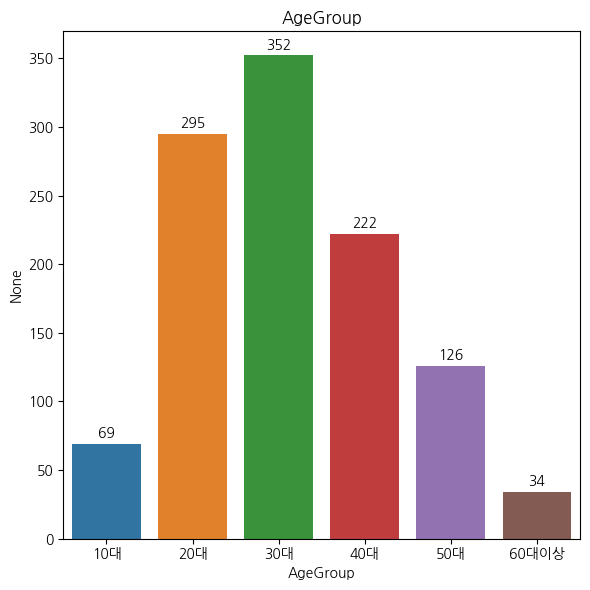

In [207]:
print_countplot(df_users_raw[["AgeGroup"]])

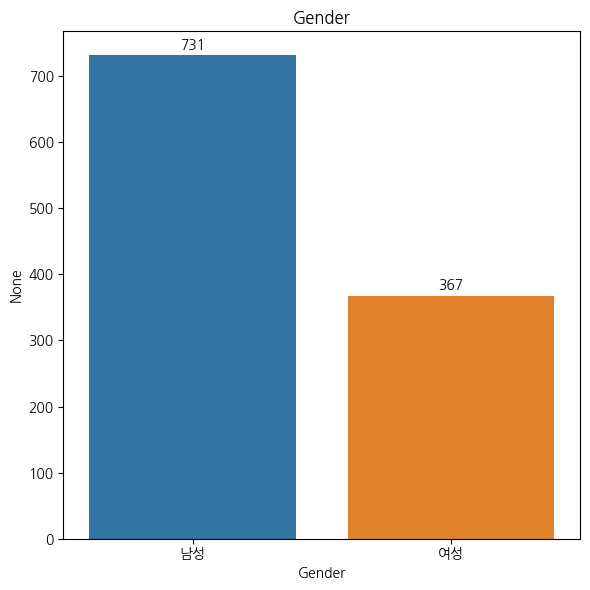

In [208]:
print_countplot(df_users_raw[["Gender"]])

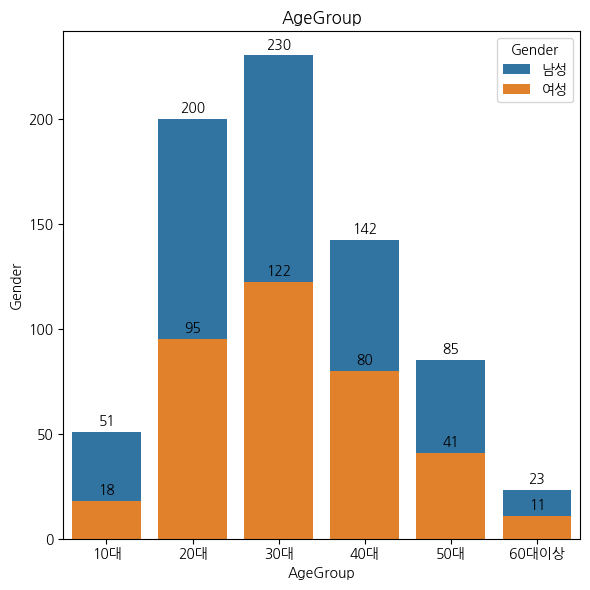

In [209]:
print_countplot(df_users_raw[["AgeGroup", "Gender"]], hue="Gender")


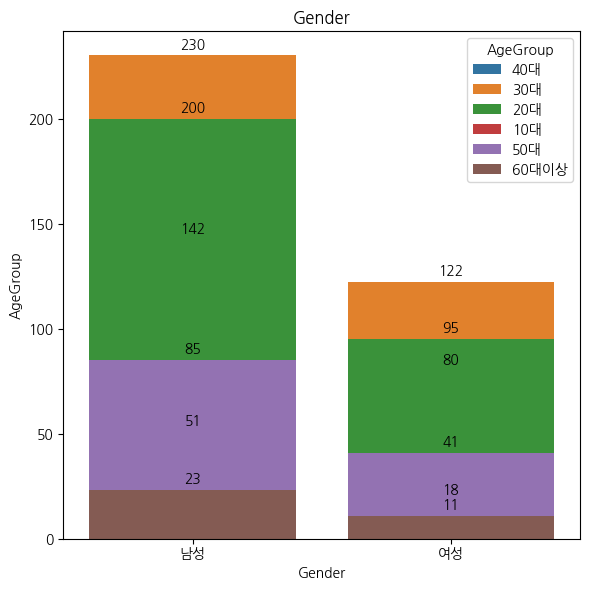

In [210]:
print_countplot(df_users_raw[["Gender","AgeGroup"]], hue="AgeGroup")


In [211]:
df_sales_raw = pd.read_csv('/home/piai/바탕화면/cvs_sales.csv')
df_sales_raw.head()

,idUser,idPOS,SalesDT,SalesDate,ItemId,ItemName
0,U101097,U101097-POS2022-10267,06112022 오후 4:08:48,2022-11-06,I-8809802264069,피)살라미마르게리따피자
1,U101094,U101094-POS2022-10233,1562022 오전 9:25:22,2022-06-15,I-8801068398441,햄)메이플더블치즈버거
2,U101066,U101066-POS2021-10337,3152021 오후 5:19:59,2021-05-31,I-8809558848506,샐)허닭케이준닭가슴살
3,U101092,U101092-POS2021-10177,0292021 오후 11:13:21,2021-09-02,I-8809383955134,주)언리미트채식삼각
4,U101066,U101066-POS2021-10648,09102021 오전 6:51:36,2021-10-09,I-8809196615119,도)고기듬뿍불고기백반


In [253]:
#df_users_raw 중에서 df_sales_raw에 존재하는 유저들만 뽑아온 데이터 프레임
#df_sales_raw에 붙일 예정
filtered_df_users_raw = df_users_raw[df_users_raw["idUser"].isin(df_sales_raw["idUser"])]
filtered_df_users_raw

,idUser,Gender,AgeGroup
0,U100001,남성,40대
276,U100277,여성,30대
277,U100278,남성,20대
278,U100279,남성,30대
279,U100280,남성,40대
...,...,...,...
1093,U101094,남성,10대
1094,U101095,남성,40대
1095,U101096,여성,30대
1096,U101097,남성,30대


In [260]:
#sales에 합치기
result = df_sales_raw.merge(filtered_df_users_raw, on='idUser', how='left')
result.head()

,idUser,idPOS,SalesDT,SalesDate,ItemId,ItemName,Gender,AgeGroup
0,U101097,U101097-POS2022-10267,06112022 오후 4:08:48,2022-11-06,I-8809802264069,피)살라미마르게리따피자,남성,30대
1,U101094,U101094-POS2022-10233,1562022 오전 9:25:22,2022-06-15,I-8801068398441,햄)메이플더블치즈버거,남성,10대
2,U101066,U101066-POS2021-10337,3152021 오후 5:19:59,2021-05-31,I-8809558848506,샐)허닭케이준닭가슴살,남성,10대
3,U101092,U101092-POS2021-10177,0292021 오후 11:13:21,2021-09-02,I-8809383955134,주)언리미트채식삼각,여성,20대
4,U101066,U101066-POS2021-10648,09102021 오전 6:51:36,2021-10-09,I-8809196615119,도)고기듬뿍불고기백반,남성,10대


In [269]:
result.groupby(["idUser","ItemName"]).size()

idUser   ItemName      
U100001  22del)헤이즐넛향1L     1
         남양)이오20s135ml     1
         오뚜기)물엿700g        1
         오뚜기)스낵면           1
U100277  20델)블랙아메리카노       1
                          ..
U101098  현대)미에로화이바병210m    1
         흥생)구운계란2입         1
         흥생)반숙계란1입         1
         흥생)품절대란15입        1
         흥양)빵빵덕레몬젤리        1
Length: 456468, dtype: int64

In [ ]:
#사용자 정의 함수

def fun_plot_hist(data, var):                                      #히스토그램 그리기
    plt.title(var)
    plt.hist(data[data["scale"]=="양품"][var], label = "양품", alpha = 0.7)
    plt.hist(data[data["scale"]=="불량"][var], label = "불량", alpha = 0.7)
    plt.legend()
    
    
def fun_print_crosstab(data, var):                                 #크로스탭(피벗테이블) 만들기
    print(pd.crosstab(index = data["scale"], columns = data[var]))
    print()
    print(pd.crosstab(index = data["scale"], columns = data[var], normalize = "columns").round(3))
    

In [ ]:
#select_dtypes(include = "number"/exclude = "number") 특정 자료형만 골라내기.
#atype 자료형 변경

df_raw_num = df_raw.select_dtypes(include = "number")
df_raw_num = df_raw_num.astype("float64")
df_raw_num

In [ ]:
#이상치 boxplot 여러 개 한 번에 그리는 함수
def print_mulitple_boxplot(data, nrows = 4, ncols = 3):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))

    for i, column in enumerate(df_raw_num.columns):
        row = i // ncols
        col = i % ncols
    df_raw_num[[column]].boxplot(ax=axs[row, col])  # Specify the ax parameter
    axs[row, col].set_title(column)

    plt.tight_layout()
    plt.show()

In [ ]:
#히스토그램 histogram 여러 개 한 번에 그리는 함수

def print_multiple_histogram(data, nrows = 4, ncols = 3):
    fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))

    for i, column in enumerate(data.select_dtypes(include = "number").columns:
        row = i // ncols
        col = i % ncols
        sns.histplot(data=df_raw, x=column, hue="scale", bins=15, kde=True, ax=axs[row, col])
        axs[row, col].set_title(column)
        axs[row, col].set_xlabel(column)
        axs[row, col].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))

def print_multiple_histogram(data, nrows = 4, ncols = 3):
    for i, column in enumerate(data.select_dtypes(include = "object").columns):
        row = i // 3
        col = i % 3
        df_groupby_total_good = df_raw[df_raw["scale"] == "양품"][column].value_counts()
        df_groupby_total_defective = df_raw[df_raw["scale"] == "불량"][column].value_counts()

        # Get a union of all unique categories in both DataFrames
        all_categories = np.union1d(df_groupby_total_good.index, df_groupby_total_defective.index)

            # Reindex the DataFrames to include all categories and fill missing values with 0
        df_groupby_total_good = df_groupby_total_good.reindex(all_categories, fill_value=0)
        df_groupby_total_defective = df_groupby_total_defective.reindex(all_categories, fill_value=0)

        width = 0.4  # 막대의 폭을 조정
        x = np.arange(len(all_categories))

        axs[row, col].bar(x, df_groupby_total_good.values, width=width, label="양품")
        axs[row, col].bar(x, df_groupby_total_defective.values, width=width, bottom=df_groupby_total_good.values, label="불량", alpha=0.7)

        axs[row, col].set_xticks(x)
        axs[row, col].set_xticklabels(all_categories, rotation=90)
        axs[row, col].set_title(column)
        axs[row, col].set_xlabel(column)
        axs[row, col].set_ylabel("Frequency")
        axs[row, col].legend()
    plt.tight_layout()
    plt.show()

In [ ]:
#누적 막대그래프 (hue)
def multiple_barplot(data, x,hue):
    sns.countplot(x = x, hue=hue, data=data, dodge=False)

    plt.title("Count Plot of Categorical Variables")
    plt.xlabel("{}".format(x))
    plt.ylabel("{}".format(hue))

    # 범례 추가
    plt.legend()

    # 그래프 보여주기
    plt.show()

    
#이상치 boxplot 여러 개 한 번에 그리는 함수
def print_countplot(data, nrows=1, ncols=2):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 6))

    for i, column in enumerate(data.columns):
        row = i // ncols
        col = i % ncols
        sns.countplot(x=column, data=data, ax=axs[col])
        axs[col].set_title(column)
        for p in axs[col].patches:
            height = int(p.get_height())
            axs[col].annotate(f'{height}', (p.get_x() + p.get_width() / 2, p.get_height()),
                        ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                        textcoords='offset points')

    plt.tight_layout()
    plt.show()
